In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

!pip install pycocotools

!pip install jupyter notebook

Looking in indexes: https://download.pytorch.org/whl/cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 6.1.12
    Uninstalling jupyter-client-6.1.12:
      Successfully uninstalled jupyter-client-6.1.12
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.5.6
    Uninstalling ipykernel-5.5.6:
    

In [8]:
import torch
import torchvision
import torch.nn as nn
import math
from  torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.rpn import AnchorGenerator

![image.png]()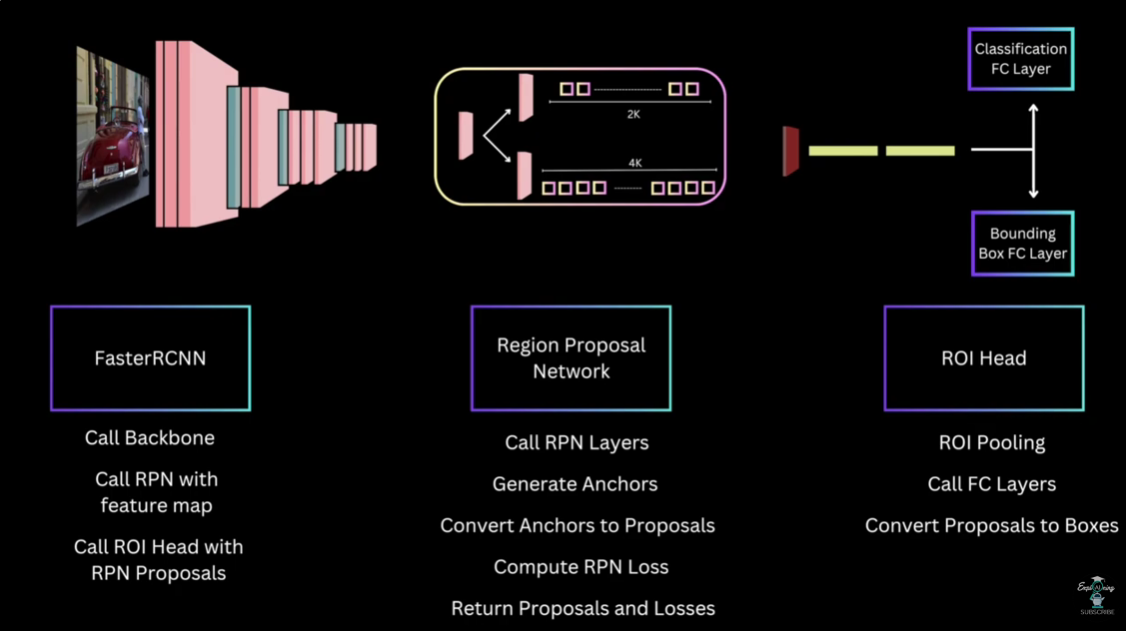

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
device

device(type='cuda')

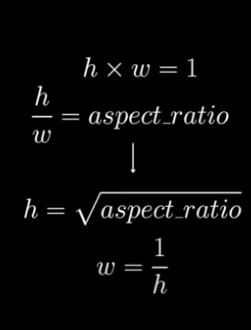

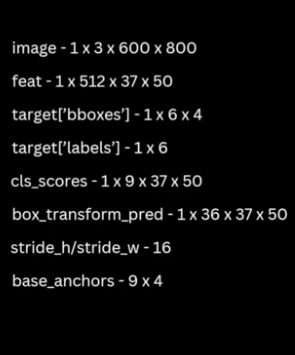

In [12]:
def get_iou(boxes1,boxes2):
  area1 = (boxes1[:,2] - boxes1[:,0]) * (boxes1[:,3] - boxes1[:,1])
  area2 = (boxes2[:,2] - boxes2[:,0]) * (boxes2[:,3] - boxes2[:,1])

  x_left = torch.max(boxes1[:,None,0],boxes2[:,0])
  y_top = torch.max(boxes1[:,None,1],boxes2[:,1])

  x_right = torch.min(boxes1[:,None,2],boxes2[:,2])
  y_bottom = torch.min(boxes1[:,None,3],boxes2[:,3])

  intersection_area = (x_right - x_left).clamp(min=0)*(y_bottom-y_top).clamp(min=0)
  union_area = area1[:,None] + area2 - intersection_area
  return intersection_area/union_area

In [11]:
def apply_regression_pred_to_anchors_or_proposals(box_transforma_pred,anchors_or_proposals):
  box_transform_pred = box_transform_pred.reshape(
      box_transforma_pred.size(0),-1,4
  )
  # get xs,cy,w,h, from x1,y1,x2,y2
  w = anchors_or_proposals[:,2] - anchors_or_proposals[:,0]
  h = anchors_or_proposals[:,3] - anchors_or_proposals[:,1]
  center_x = anchors_or_proposals[:,0] + 0.5*w
  center_y = anchors_or_proposals[:,1] + 0.5*h
  #apply prediciotns

  dx = box_transform_pred[...,0]
  dy = box_transform_pred[...,1]
  dw = box_transform_pred[...,2]
  dh = box_transform_pred[...,3]

  pred_center_x = dx*w[:,None] + center_x[:,None]
  pred_center_y = dy*h[:,None] + center_y[:,None]
  pred_w = torch.exp(dw)*w[:,None]
  pred_h = torch.exp(dh)*h[:,None]

  pred_box_x1 = pred_center_x - 0.5* pred_w
  pred_box_y1 = pred_center_y - 0.5*pred_h
  pred_box_x2 = pred_center_x + 0.5*pred_w
  pred_box_y2 = pred_center_y + 0.5*pred_h

  pred_boxes = torch.stack((pred_box_x1,pred_box_y1,pred_box_x2,pred_box_y2),dim=2)
  return pred_boxes


In [13]:
def clamp_boxes_to_image_boundary(boxes,image_shape):
  boxes_x1 = boxes[...,0]
  boxes_y1 = boxes[...,1]
  boxes_x2 = boxes[...,2]
  boxes_y2 = boxes[...,3]
  height,width = image_shape[-2:]
  boxes_x1 = torch.clamp(min=0,max=width)
  boxes_y1 = torch.clamp(min=0,max=height)
  boxes_x2 = torch.clamp(min=0,max=width)
  boxes_y2 = torch.clamp(min=0,max=height)

  boxes = torch.cat((
      boxes_x1[...,None],
      boxes_y1[...,None],
      boxes_x2[...,None],
      boxes_y2[...,None]
  ),dim=-1)
  return boxes

In [14]:
def boxes_to_transformation_targets(ground_truth_boxes,anchors_or_proposals):
  widths = anchors_or_proposals[:,2] - anchors_or_proposals[:,0]
  heights = anchors_or_proposals[:,3] - anchors_or_proposals[:,1]
  center_x = anchors_or_proposals[:,0] + 0.5*widths
  center_y = anchors_or_proposals[:,1] + 0.5 *heights

  #get center_x,center_y,w,h,from x1,y1,x2,y2

  gt_widths = ground_truth_boxes[:,2]-ground_truth_boxes[:,0]
  gt_heights = ground_truth_boxes[:,3]-ground_truth_boxes[:,1]
  gt_center_x = ground_truth_boxes[:,0] + 0.5*gt_widths
  gt_center_y = ground_truth_boxes[:,1] + 0.5*gt_heights

  target_dx = (gt_center_x - center_x)/widths
  target_dy = (gt_center_y - center_y)/heights
  target_dw = torch.log(gt_widths/widths)
  target_dh = torch.log(gt_heights/heights)

  regression_targets = torch.stack((target_dx,target_dy,target_dw,target_dh),dim=1)
  return regression_targets

In [16]:
def sample_positive_negative(labels,positive_count,total_count):
  positive = torch.where(labels>=1)[0]
  negative = torch.where(labels==0)[0]
  num_pos = positive_count
  num_pos = min(positive.numel(),num_pos)
  num_neg = total_count - num_pos
  num_neg = min(negative.numel(),num_neg)
  perm_positive_idx = torch.randperm(positive.numel(),device=positive.device)[:num_pos]
  perm_negative_idx = torch.randperm(negative.numel(),device=negative.device)[:num_neg]
  pos_idxs = positive[perm_positive_idx]
  neg_idxs = negative[perm_negative_idx]
  sampled_pos_idx_mask = torch.zeros_like(labels,dtype=torch.bool)
  sampled_neg_idx_mask =torch.zeros_like(labels,dtype=torch.bool)

  sampled_pos_idx_mask[pos_idxs] = True
  sampled_neg_idx_mask[neg_idxs] = True
  return sampled_pos_idx_mask,sampled_neg_idx_mask

In [19]:
def transform_boxes_to_original_size(boxes,new_size,original_size):
    ratios = [
        torch.tensor(s_orig,device=boxes.device,dtype= torch.float32)/
        torch.tensor(s,dtype=torch.float32,device=boxes.device)
        for s_orig,s in zip(original_size,new_size)
    ]
    ratio_height,ratio_width = ratios
    xmin,ymin,xmax,ymax = boxes.unbind(1)
    xmin = xmin/ratio_width
    xmax = xmax/ratio_width
    ymin = ymin/ratio_height
    ymax = ymax/ratio_height
    return torch.stack((xmin,ymin,xmax,ymax),dim=1)

In [17]:
#RegionProposalNetwork
class RegionProposalNetwork(nn.Module):
  def __init__(self,in_channel = 512):
    super(RegionProposalNetwork,self).__init__()
    self.scales = [128,256,512]
    self.aspect_ratios = [0.5,1,2]
    self.num_anchors = len(self.scales) * len(self.aspect_ratios)

    #3*3 conv
    self.rpn_conv = nn.Conv2d(in_channel,in_channel,kernel_size=3,stride=1,padding=1)
    #1*1 conv
    self.cls_layer = nn.Conv2d(in_channel,self.num_anchors,kernel_size=1,stride=1)
    #1*1 regression
    self.bbox_reg_layer = nn.Conv2d(in_channel,self.num_anchors*4,kernel_size=1,stride=1)

  def assign_targets_to_anchors(self,anchors,gt_boxes):
    iou_matrix = get_iou(gt_boxes,anchors)
    best_match_iou ,best_match_gt_index = iou_matrix.max(dim=0)
    best_match_gt_idx_pre_threshold = best_match_gt_index.clone()
    below_low_threshold = best_match_iou < 0.3
    between_threshold = (best_match_iou>=0.3) &(best_match_iou<0.7)
    best_match_gt_index[below_low_threshold] = -1
    best_match_gt_index[between_threshold]=-2

    #low quality anchor boxes
    best_anchor_iou_for_gt,_ = iou_matrix.max(dim=1)
    gt_pred_pair_with_highest_iou = torch.where(iou_matrix== best_anchor_iou_for_gt)

    pred_inds_to_update = gt_pred_pair_with_highest_iou[1]
    best_match_gt_index[pred_inds_to_update] = best_match_gt_idx_pre_threshold[pred_inds_to_update]

    matched_gt_boxes = gt_boxes[best_match_gt_index.clamp(min=0)]

    #set alll forgrounf anchor labels as 1
    labels = best_match_gt_index >=0

    labels = labels.to(dtype=torch.float32)

    #set all background labels as  0
    background_anchors = best_match_gt_index == -1
    labels[background_anchors] = 0.0
    ignored_anchors = best_match_gt_index == -2
    labels[ignored_anchors] = -1.0
    return labels,matched_gt_boxes

  def filter_proposals(self,proposals,cls_scores,image_shape):
    cls_scores = cls_scores.reshape(-1)
    cls_scores = torch.sigmoid(cls_scores)
    _,top_n_idx = cls_scores.topk(10000)
    proposals = proposals[top_n_idx]
    cls_scores = cls_scores[top_n_idx]
    proposals = clamp_boxes_to_image_boundary(proposals,image_shape)
    #NMS Based on objectness
    keep_mask = torch.zeros_like(cls_scores,dtype = torch.bool)
    keep_indices = torch.ops.torchvision.nms(proposals,cls_scores,0.7)

    post_nms_keep_indices = keep_indices[
        cls_scores[keep_indices].sort(descending=True)
    ]
    proposals = proposals[post_nms_keep_indices[:2000]]
    cls_scores = cls_scores[post_nms_keep_indices[:2000]]
    return proposals,cls_scores


  def generate_anchors(self,image,feat):
    grid_h,grid_w = feat.shape[-2:]
    image_h,image_w = image.shape[-2:]
    stride_h = torch.tensor(image_h//grid_h,dtype=torch.int64,device = feat.device)
    stride_w = torch.tensor(image_w//grid_w,dtype = torch.int64,device = feat.device)
    scales = torch.as_tensor(self.scales,dtype=feat.dtype,device= feat.device)
    aspect_ratios = torch.as_tensor(self.aspect_ratios,dtype=feat.dtype,device=feat.device)
    h_ratios = torch.sqrt(aspect_ratios)
    w_ratios = 1/h_ratios
    ws = (w_ratios[:,None]* scales[None,:]).view(-1)
    hs = (h_ratios[:,None]* scales[None,:]).view(-1)

    base_anchors = torch.stack([-ws,-hs,ws,hs],dim=1)/2
    base_anchors = base_anchors.round()
    shifts_x = torch.arange(0,grid_w,dtype = torch.int32,device=feat.device)*stride_w
    shifts_y = torch.arange(0,grid_h,dtype = torch.int32,device=feat.device)*stride_h
    shifts_x,shifts_y = torch.meshgrid(shifts_x,shifts_y,indexing='ij')
    #(H-feat,W_feat)
    shifts_x = shifts_x.reshape(-1)
    shifts_y = shifts_y.reshape(-1)
    shifts = torch.stack((shifts_x,shifts_y,shifts_x,shifts_y),dim=1)

    #shift -> (H-feat*W_feat,4)
    #base anchor -> num_anchor_per_location,4
    #shift -> (H_feat*W_feat,4)
    anchors = (shifts.view(-1,1,4) + base_anchors.view(1,-1,4))
    anchors = anchors.reshape(-1,4)
    #anchors => H_feat*W-feat,num_anchor_per_location ,4
    return anchors


  def forward(self,image,feat,target):
    #call RPN Layers
    rpn_feat = nn.ReLU()(self.rpn_conv(feat))
    cls_scores = self.cls_layer(rpn_feat)
    box_transform_pred = self.bbox_reg_layer(rpn_feat)
    #generate anchors
    anchors = self.generate_anchors(image,feat)
    number_of_anchors_per_location = cls_scores.size(1)

    cls_scores = cls_scores.permute(0,2,3,1)
    cls_scores = cls_scores.reshape(-1,1)

    box_transform_pred = box_transform_pred.view(
        box_transform_pred.size(0),
        number_of_anchors_per_location,
        4,
        rpn_feat.shape[-2],
        rpn_feat.shape[-1]
    )
    box_transform_pred = box_transform_pred.permute(0,3,4,1,2)
    box_transform_pred = box_transform_pred.reshape(-1,4)
    #box_transform_pred - > (B*H_feat*W_feat+Number of anchors per location,H_feat,W_fear)

    proposals = apply_regression_pred_to_anchors_or_proposals(
        box_transform_pred.detach().reshape(-1,1,4),anchors
    )
    proposals = proposals.reshape(proposals.size(0),4)

    proposals,scores = self.filter_proposals(proposals,cls_scores.detach(),image.shape)

    rpn_output = {
        'proposals':proposals,'scores':scores
    }
    if not self.training or target is None:
      return rpn_output
    else :
      labels_for_anchors,matched_gt_boxes_for_Anchors = self.assign_targets_to_anchors(
          anchors,target['bboxes'][0]
      )

      regression_targets = boxes_to_transformation_targets(
          matched_gt_boxes_for_Anchors,anchors
      )

      sampled_neg_idx_mask,sampled_pos_idx_mask = sample_positive_negative(
          labels_for_anchors,positive_count=128,total_count=256
      )
      sampled_idx = torch.where(sampled_pos_idx_mask | sampled_neg_idx_mask)[0]

      localization_loss = (
          torch.nn.functional.smooth_l1_loss(
              box_transform_pred[sampled_pos_idx_mask],
              regression_targets[sampled_pos_idx_mask],
              beta = 1/9,
              reduction = 'sum'
          )/(sampled_idx.numel())
      )

      cls_loss = torch.nn.functional.binary_cross_entropy_with_logits(
          cls_scores[sampled_idx].flatten(),
          labels_for_anchors[sampled_idx].flatten()
      )

      rpn_output['rpn_classification_loss'] = cls_loss
      rpn_output['rpn_classification_loss'] = localization_loss
      return rpn_output



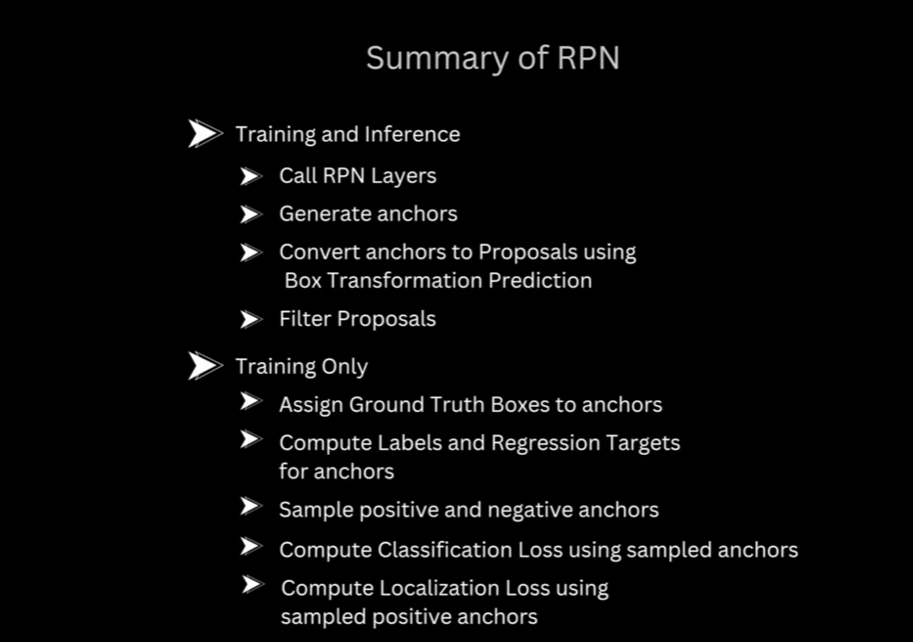

#ROI heads

In [18]:
class ROIHead(nn.Module):
  def __init__(self,num_classes = 21,in_channels=512):
    super(ROIHead,self).__init__()
    self.num_classes = num_classes
    self.in_channels = in_channels
    self.pool_size = 7
    self.fc_inner_dim = 1024
    self.fc6 = nn.Linear(in_channels*self.pool_size*self.pool_size,self.fc_inner_dim)
    self.fc7 = nn.Linear(self.fc_inner_dim,self.fc_inner_dim)
    self.cls_score = nn.Linear(self.fc_inner_dim,self.num_classes)
    self.bbox_pred = nn.Linear(self.fc_inner_dim,self.num_classes*4)

  def assign_target_to_proposals(self,proposals,gt_boxes,gt_labels):
    iou_matrix = get_iou(gt_boxes,proposals)
    best_match_iou ,best_match_gt_idx = iou_matrix.max(dim=0)
    below_low_threshold = best_match_iou < 0.5
    best_match_gt_idx[below_low_threshold] = -1
    matched_gt_boxes_for_proposals = gt_boxes[best_match_gt_idx.clamp(min=0)]

    labels = gt_labels[best_match_gt_idx.clamp(min=0)]
    labels = labels.to(dtype=torch.int64)

    background_proposals = best_match_gt_idx == -1
    labels[background_proposals] = 0
    return labels,matched_gt_boxes_for_proposals

  def fiter_predictions(self,pred_boxes,pred_labels,pred_scores):
    keep = torch.where(pred_scores > 0.05)[0]
    pred_boxes,pred_scores,pred_labels = pred_boxes[keep],pred_scores[keep],pred_labels[keep]

    min_size =1
    ws,hs = pred_boxes[:,2] - pred_boxes[:,0],pred_boxes[:,3] - pred_boxes[:,1]
    keep = torch.where((ws >= min_size) & (hs >= min_size))[0]
    pred_boxes ,pred_scores ,pred_labels = pred_boxes[keep],pred_scores[keep],pred_labels[keep]

    #class wise nms

    keep_mask = torch.zeros_like(pred_scores,dtype=torch.bool)
    for class_id in torch.unique(pred_labels):
      curr_indices = torch.where(pred_labels == class_id)[0]
      curr_keep_indices = torch.ops.torchvision.nms(
          pred_boxes[curr_indices],
          pred_scores[curr_indices],
          iou_threshold=0.5
      )
      keep_mask[curr_indices[curr_keep_indices]] = True
    keep_indices = torch.where(keep_mask)[0]
    post_nms_keep_indices = keep_indices[pred_labels[keep_indices].sort(
        descending=True
    )[1]]
    keep = post_nms_keep_indices[:100]
    pred_boxes,pred_scores,pred_labels = pred_boxes[keep],pred_scores[keep],pred_labels[keep]
    return pred_boxes,pred_scores,pred_labels



  def forward(self, feat, proposals, image_shape, target):
      # Training mode with ground truth available
      if self.training and target is not None:
          gt_boxes = target['bboxes'][0]
          gt_labels = target['labels'][0]

          # Assign labels and ground truth boxes to proposals
          labels, matched_gt_boxes_for_proposals = self.assign_target_to_proposals(proposals, gt_boxes, gt_labels)

          # Sample positive and negative proposals
          sampled_neg_idx_mask, sampled_pos_idx_mask = sample_positive_negative(
              labels, positive_count=32, total_count=128
          )
          sampled_idxs = torch.where(sampled_pos_idx_mask | sampled_neg_idx_mask)[0]

          # Filter proposals based on sampling
          proposals = proposals[sampled_idxs]
          labels = labels[sampled_idxs]
          matched_gt_boxes_for_proposals = matched_gt_boxes_for_proposals[sampled_idxs]

          # Compute regression targets
          regression_targets = boxes_to_transformation_targets(
              matched_gt_boxes_for_proposals, proposals
          )

          # ROI Pooling
          spatial_scale = 0.00625
          proposal_roi_pool_feats = torchvision.ops.roi_pool(
              feat,
              boxes=proposals,
              output_size=self.pool_size,
              spatial_scale=spatial_scale
          )

          # Feature processing
          proposal_roi_pool_feats = proposal_roi_pool_feats.flatten(start_dim=1)
          box_fc_6 = torch.nn.functional.relu(self.fc6(proposal_roi_pool_feats))
          box_fc_7 = torch.nn.functional.relu(self.fc7(box_fc_6))

          # Classification and regression predictions
          cls_scores = self.cls_score(box_fc_7)
          box_transform_pred = self.bbox_pred(box_fc_7)

          # Compute losses
          classification_loss = torch.nn.functional.cross_entropy(
              cls_scores, labels
          )

          # Localization loss only for foreground proposals
          fg_proposal_idx = torch.where(labels > 0)[0]
          localization_loss = torch.nn.functional.smooth_l1_loss(
              box_transform_pred[fg_proposal_idx, labels[fg_proposal_idx] * 4 : (labels[fg_proposal_idx] + 1) * 4],
              regression_targets[fg_proposal_idx],
              beta=1/9,
              reduction='sum'
          ) / max(1, fg_proposal_idx.numel())

          return {
              'frcnn_classification_loss': classification_loss,
              'frcnn_localization_loss': localization_loss
          }

      # Inference mode
      else:
          # ROI Pooling
          spatial_scale = 0.00625
          proposal_roi_pool_feats = torchvision.ops.roi_pool(
              feat,
              boxes=proposals,
              output_size=self.pool_size,
              spatial_scale=spatial_scale
          )

          # Feature processing
          proposal_roi_pool_feats = proposal_roi_pool_feats.flatten(start_dim=1)
          box_fc_6 = torch.nn.functional.relu(self.fc6(proposal_roi_pool_feats))
          box_fc_7 = torch.nn.functional.relu(self.fc7(box_fc_6))

          # Classification and regression predictions
          cls_scores = self.cls_score(box_fc_7)
          box_transform_pred = self.bbox_pred(box_fc_7)

          # Convert predictions to probabilities
          pred_scores = torch.softmax(cls_scores, dim=-1)
          pred_labels = torch.argmax(pred_scores, dim=-1)

          # Apply box regression
          pred_boxes = apply_regression_pred_to_anchors_or_proposals(
              box_transform_pred, proposals
          )

          # Clamp boxes to image boundary
          pred_boxes = clamp_boxes_to_image_boundary(pred_boxes, image_shape)

          # Filter predictions
          pred_boxes, pred_scores, pred_labels = self.filter_predictions(
              pred_boxes, pred_scores, pred_labels
          )

          return {
              'pred_boxes': pred_boxes,
              'pred_scores': pred_scores,
              'pred_labels': pred_labels
          }


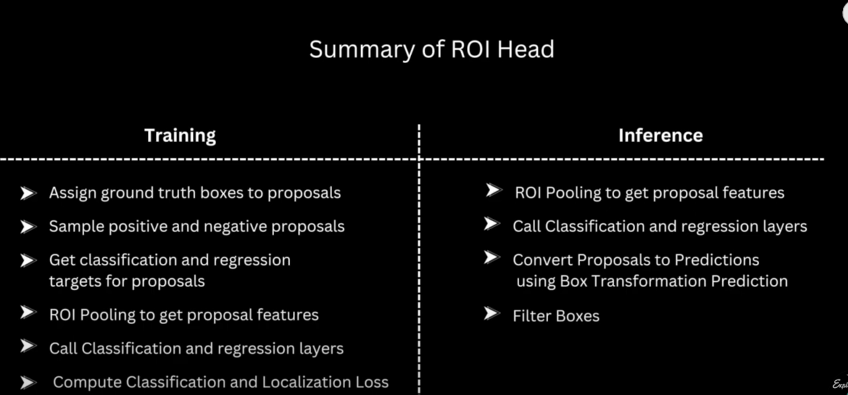

In [20]:
class FastRCNN(nn.Module):
  def __init__(self,num_classes=21):
    super(FastRCNN,self).__init__()
    vgg16 = torchvision.models.vgg16(pretrained=True)
    self.backbone = vgg16.features[:-1]
    self.rpn = RegionProposalNetwork(in_channel=512)
    self.roi_head = ROIHead(num_classes=num_classes,in_channels=512)

    for layer in self.backbone[:10]:
        for p in layer.parameters():
            p.requires_grad = False
    self.image_mean = [0.485,0.456,0.406]
    self.image_std = [0.229,0.224,0.225]
    self.min_size = 600
    self.max_size = 1000

  def normalize_resize_image_and_boxes(self,image,bboxes):
    mean = torch.as_tensor(self.image_mean,dtype=image.dtype,device=image.device)
    std = torch.as_tensor(self.image_std,dtype=image.dtype,device=image.device)
    image = (image-mean[:,None,None])/std[:,None,None]
    h,w = image.shape[-2:]
    im_shape = torch.tensor(image.shape[-2:])
    min_size = float(torch.min(im_shape))
    max_size = float(torch.max(im_shape))
    scale_factor = torch.min(float(self.min_size)/min_size,float(self.max_size)/max_size)
    scale_factor = scale_factor.item()
    image = torch.nn.functional.interpolate(
        image,size=None,scale_factor = scale_factor,mode='bilinear',recompute_scale_factor=True,align_corners=False
    )
    #resize bboxes
    if bboxes is not None:
      ratios = [torch.tensor(s,dtype=torch.float32,device=bboxes.device)/
                torch.tensor(s_orig,dtype=torch.float32,device=bboxes.device)
                for s,s_orig in zip(image.shape[-2:],(h,w))

      ]
      ratio_height,ratio_width= ratios
      xmin,ymin,xmax,ymax = bbox.unbind(2)
      xmin = xmin*ratio_width
      xmax = xmax*ratio_width
      ymin = ymin*ratio_height
      ymax = ymax*ratio_height
      bboxes = torch.stack((xmin,ymin,xmax,ymax),dim=2)
      return image,bboxes

  def forward(self,image,target=None):
    old_shape=image.shape[-2:]
    if self.training:
      image,bboxes = self.normalize_resize_image_and_boxes(image,target['bboxes']
                                                           )
      target['bboxes'] = bboxes
    else:
      image,bboxes = self.normalize_resize_image_and_boxes(image,None)
    features = self.backbone(image)

    #call RPN and get proposals
    rpn_output = self.rpn(image,features,target)
    proposals = rpn_output['proposals']

    #call ROI head and convert proposals to boxes
    frcnn_output = self.roi_head(features,proposals,image.shape[-2:],target)

    if not self.training:
      frcnn_output['boxes'] = transform_boxes_to_original_size(
          frcnn_output['boxes'],
          image.shape[-2:],
          old_shape
      )

    return rpn_output,frcnn_output

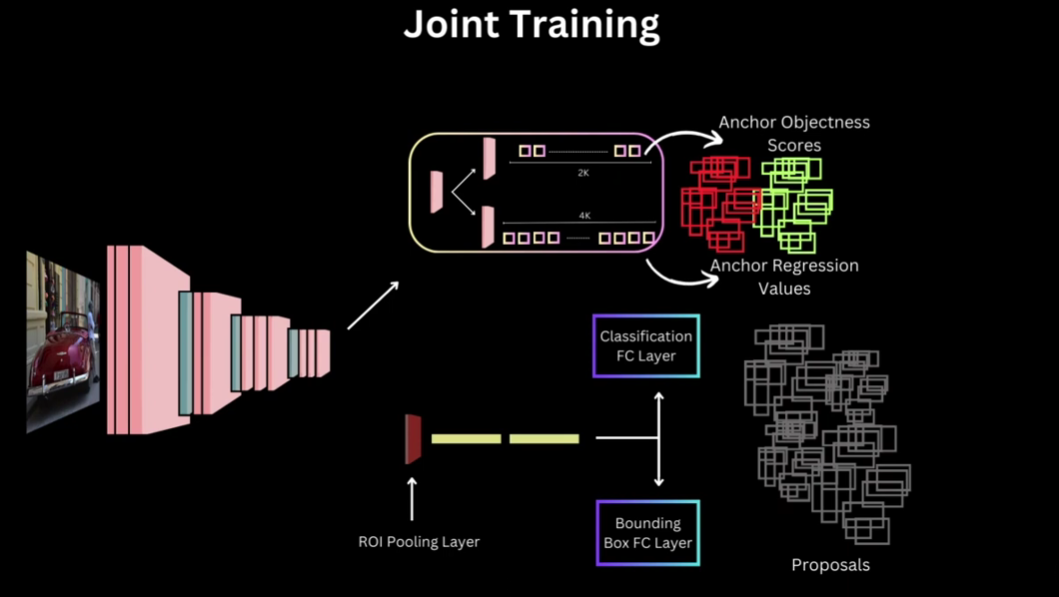